## Lidar Metric Test Script
*For testing out new metrics to add to Functions.py.* 
<p>PB 10/03/2022</p>

### Plan for Processing

0. Compute Height for all las tiles (preprocessing)
    <p>
0. Make las tile boundaries as shapefiles (for quality checking)
    <p>
1. Clip Point Clouds to shapefiles
    - Load corresponding cloud
    - Clip buffer points
    - Clip and save new point clouds (one set for each shapefile)
    <p>
3. Compute metrics
    - Grid metrics: 
        - open each cloud, grid them, compute stats based on the grid cell
        - compute and save the aggregated (whole plot) metrics as a csv and shapefile (%grass, tree, or shrub, etc.)
        - save the gridded metrics (FHP per cell, etc.) as a netcdf for visualization 
    - Whole Plot metrics: 
        - open each cloud, compute stats based on all points in plot
        - save as a csv and shapefile.
    

In [1]:
# Import Dependencies
import sys
sys.path.append('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/bin/')
from Functions import calccover, calcPercentileHeights, calcLasHeight
from Classes import Cloud
import geopandas as gpd
import pandas as pd
import numpy as np
import concurrent.futures
from pathlib import Path
import laspy
import time
import matplotlib.pyplot as plt


# # # USER INPUTS

# Path to a shapefile (.shp) of polygon features matching the las files
# NOTE: This should be the same input shapefile as in 1-ClipLasWithPolygons.ipynb
# shpf = Path('./data/in/test/testtreeshp/BuffCamp100m_010m_CrownPolygons_3msmooth_fenceremoved_10cmAreaShrubsRemoved.shp')

# Input directory of clipped las files to compute metrics with.
# NOTE: This should be the same as the 'od' directory from 1-ClipLasWithPolygons.ipynb
ld = Path('./data/in/test/testtreelas/')

# outdirectory for metric output files
od_metrics = Path('./data/out/test/metrics/')

# epsg of the shapefile and the las files, as a string
# Kruger is 32736 (WGS84 UTM 36S)
# Mpala is 32637 (WGS84 UTM 37N)
epsg='32637'

# feature id column - unique ID for each feature in the shapefile
# NOTE: Should match the file names of the las files in 'ld' directory.
featureIDcol = 'treeID'

# Max height of voxel stacks 
# NOTE: Set this to be just above max height of your trees in meters.
stackheight=15

# Horizontal Res of Grid (XY pixel size)
xysize=1

# Vertical step size for metrics
# NOTE: This defines the vertical bin size in meters (how "thick" each voxel is).
metricstep = 0.25

# Ground threshold (i.e. below this height treat points as ground) in meters
groundthreshold = 0.05

# height col
heightcol = 'HeightAboveGround'

# # # END USER INPUTS

In [2]:
# # Use site 5 and transects 7 and 8 for testing
# lasd = Path('/n/davies_lab/Users/pbb/SelenkayDiversity/data/in/PointClouds_Outside')

# # shapefile directories
# shpd = Path('/n/home02/pbb/scripts/halo-metadata-server/Selenkay/data/in/BoundaryShapefiles/SelenkaySpotPolygons_IncreasingRadius')

# # make input shapefile names
# radiuses = [10, 20, 30, 50, 80, 130]

# shpfs = []
# for r in radiuses:
#     shpfs.append(f'{str(shpd)}/SelenkaySpotPolygons_{r}mRadius.shp')

In [3]:
lf

-rw-r--r-- 1 pbb 11048 Oct 17 17:30 0-1-ComputeHeightExportLasFiles_Inside.ipynb
-rw-r--r-- 1 pbb  4478 Oct 17 17:23 0-2-ComputeHeightExportLasFiles_Outside.ipynb
-rw-r--r-- 1 pbb  8441 Oct 17 16:11 0-3-LasBBoxShapefile.ipynb
-rw-r--r-- 1 pbb 11715 Oct 12 17:03 1-ClipLasWithPolygons_Selenkay.ipynb
-rw-r--r-- 1 pbb 14098 Oct 18 10:28 2-ProcessPickleMetrics.ipynb


### Grid Metrics

In [4]:
# Get las file
lf = [l for l in ld.glob('*.las')][0]

# Preprocess (just for the test file)
meta = calcLasHeight(inf=lf,
                     opath='./data/in/test/testtreelas/',
                     buffer=0)

newname = lf.name.split('.')[0] + '_Height.las'

lf_new = f'{lf.parent}/{newname}'

# Read the new file in laspy
l = laspy.read(lf_new)

# Print out the dimension names
for n in l.header.point_format.dimension_names:
    print(n)

X
Y
Z
intensity
return_number
number_of_returns
scan_direction_flag
edge_of_flight_line
classification
synthetic
key_point
withheld
scan_angle_rank
user_data
point_source_id
gps_time
red
green
blue
HeightAboveGround


In [5]:
# Wrapper function for using parallel processing and calccover function 
# Notice that is calls lc as the first argument
# need to write it this way in order to use concurrent futures parallel processing below
def calccover_parallel(index, calculatecover=True):

    # make a True/False array 
    # for all points within the current grid cell
    idx_bool = lc.grid_dict['idx_points'] == lc.grid_dict['idx_cells'][index]
    
    if calculatecover:
        
        try:
            
            # Calculate Cover - treating anything [-5 cm - 0 cm] as a ground hit
            cover = calccover(points=lc.las.points[idx_bool],
                              step=lc.vsize,
                              groundthres=groundthreshold)
            
        except Exception as e:
            
            print(f"{e.__class__} for {lc.lasf}: \n")
            print(f"\t{e}\n")
    
    # Calculate Percentile Metrics of Height
    perc_dict= {0:[],
                25:[],
                50:[],
                75:[],
                98:[],
                100:[],
                'mean':[],
                'std':[]}
    
    # Get Heights for given cell
    heights = lc.las.points[heightcol][idx_bool]

    perc_dict[0].append(np.quantile(heights, [0]).flat[0])
    perc_dict[25].append(np.quantile(heights, [0.25]).flat[0])
    perc_dict[50].append(np.quantile(heights, [0.5]).flat[0])
    perc_dict[75].append(np.quantile(heights, [0.75]).flat[0])
    perc_dict[98].append(np.quantile(heights, [0.98]).flat[0])
    perc_dict[100].append(np.quantile(heights, [1.0]).flat[0])
    perc_dict['mean'].append(np.mean(heights).flat[0])
    perc_dict['std'].append(np.std(heights).flat[0])

    if calculatecover:
        # Return cover dict, percentile dict, and height list (for quick recalculation of anything later)
        return cover, perc_dict, heights
    else:
        return perc_dict, heights

In [6]:
### STEP 1: Load in Cloud 
startproj = time.time()

# Make a las cloud class, and grid it
lc = Cloud(lasf=lf_new,
           gridsize=xysize,
           vsize=metricstep,
           heightcol='HeightAboveGround',
           classcol='classification',
           maxh=stackheight)

# get project string for saving below
projstr = lc.lasf.split('/')[-1].split('_')[0]

end = time.time()
print(f'Loaded {projstr} cloud, time elapsed: {end - startproj}\n')

Loaded tree1054 cloud, time elapsed: 0.012435197830200195



In [7]:
### STEP 2: Make the grid
start = time.time()

lc.makegrid()

end = time.time()
print(f'Grid created, time elapsed: {end - start}\n')

Grid created, time elapsed: 0.19045472145080566



In [8]:
### STEP 3: Compute Cover, FHP, and Percentiles Metrics Over the Cloud's Grid
start = time.time()

# initialize cover dictionary for output 
lc.cover_dict = {}
lc.perc_dict = {}
lc.height_dict = {}

# set the cell indices to loop over in parallel
indices = lc.grid_dict['idx_cells']

# Use concurrent futures to compute cover over each cell in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=None) as executor:
    for cph, x, y in zip(executor.map(calccover_parallel, indices),
                             lc.grid_dict['x_cells'],
                             lc.grid_dict['y_cells']):

        # Stick the cover, perc, and heights inside the metrics dictionary
        # with x and y location as tuple keys
        lc.cover_dict[(x, y)] = cph[0]
        lc.perc_dict[(x, y)] = cph[1]
        lc.height_dict[(x, y)] = np.round(cph[2], decimals=3)

end = time.time()
print(f'Metrics computed, time elapsed: {end - start}\n')

Metrics computed, time elapsed: 2.1477513313293457



### Aggregate Grid Metrics

In [9]:
# Get x and y keys for plotting
X = [k[0] for k in lc.cover_dict.keys()]
Y = [k[1] for k in lc.cover_dict.keys()]

In [10]:
# Function to compute aggregate pixel metrics based on height
def heightAggMetrics(perc_dict):
    
    # Get max heights and std heights
    maxH = np.array([v[98][0] for v in perc_dict.values()])
    meanH = np.array([v['mean'][0] for v in perc_dict.values()])
    stdH = np.array([v['std'][0] for v in perc_dict.values()])
    
    # initialize output stats dict
    stats = {}
    
    # Fill Stat dict
    
    # Horizontal variation in max height
    stats['max(maxH)'] = np.max(maxH)
    stats['min(maxH)'] = np.min(maxH)
    stats['range(maxH)'] = np.max(maxH) - np.min(maxH)
    stats['mean(maxH)'] = np.mean(maxH)
    stats['std(maxH)'] = np.std(maxH)
    stats['cv(maxH)'] = np.std(maxH) / np.mean(maxH)
    stats['median(maxH)'] = np.median(maxH)
    stats['iqr(maxH)'] = np.percentile(maxH, q=75) - np.percentile(maxH, q=50)
    
    # Stats of vertical deviation in point heights
    stats['mean(sdH)'] = np.mean(stdH)
    stats['sd(sdH)'] = np.std(stdH)
    stats['mean(cvH)'] = np.mean(stdH/meanH)
    stats['sd(cvH)'] = np.std(stdH/meanH)
    
    # Vegetation proportional cover and other stats
    # using veg. classes based on thresholds of max heights of pixels
    
    ground_idx = (maxH <= groundthreshold)
    grass_idx = ((maxH > groundthreshold) & (maxH <= 0.5))
    shrub_idx = ((maxH > 0.5) & (maxH <= 3))
    tree_idx = (maxH > 3)
    woody_idx = (maxH > 1)
    
    stats['cover_ground_maxH'] = np.sum(ground_idx) / np.size(maxH)
    stats['cover_grass_maxH'] = np.sum(grass_idx) / np.size(maxH)
    stats['cover_shrub_maxH'] = np.sum(shrub_idx) / np.size(maxH)
    stats['cover_tree_maxH'] = np.sum(tree_idx) / np.size(maxH)
    stats['cover_woody_maxH'] = np.sum( woody_idx ) / np.size(maxH)
    
    # Point cloud height stats (Rappaport et al., 2018)
    # Grass
    stats['mean(sdH)_grass'] = np.mean(stdH[grass_idx])
    stats['sd(sdH)_grass'] = np.std(stdH[grass_idx])
    stats['mean(cvH)_grass'] = np.mean(stdH[grass_idx]/meanH[grass_idx])
    stats['sd(cvH)_grass'] = np.std(stdH[grass_idx]/meanH[grass_idx])
    
    # Shrub
    stats['mean(sdH)_shrub'] = np.mean(stdH[shrub_idx])
    stats['sd(sdH)_shrub'] = np.std(stdH[shrub_idx])
    stats['mean(cvH)_shrub'] = np.mean(stdH[shrub_idx]/meanH[shrub_idx])
    stats['sd(cvH)_shrub'] = np.std(stdH[shrub_idx]/meanH[shrub_idx])
    
    # Tree
    stats['mean(sdH)_tree'] = np.mean(stdH[tree_idx])
    stats['sd(sdH)_tree'] = np.std(stdH[tree_idx])
    stats['mean(cvH)_tree'] = np.mean(stdH[tree_idx]/meanH[tree_idx])
    stats['sd(cvH)_tree'] = np.std(stdH[tree_idx]/meanH[tree_idx])
    
    # Woody
    stats['mean(sdH)_woody'] = np.mean(stdH[woody_idx])
    stats['sd(sdH)_woody'] = np.std(stdH[woody_idx])
    stats['mean(cvH)_woody'] = np.mean(stdH[woody_idx]/meanH[woody_idx])
    stats['sd(cvH)_woody'] = np.std(stdH[woody_idx]/meanH[woody_idx])
    
    # Round everything to 3 decimal points
    for k in stats.keys():
        stats[k] = np.round(stats[k], 3)
    
    return stats

In [11]:
# it works!
statsH = heightAggMetrics(lc.perc_dict)
# statsH['cover_grass'] + statsH['cover_shrub'] + statsH['cover_tree'] + statsH['cover_ground']
statsH

/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


{'max(maxH)': 13.962,
 'min(maxH)': -0.038,
 'range(maxH)': 14.0,
 'mean(maxH)': 10.509,
 'std(maxH)': 3.53,
 'cv(maxH)': 0.336,
 'median(maxH)': 11.359,
 'iqr(maxH)': 1.617,
 'mean(sdH)': 4.132,
 'sd(sdH)': 1.407,
 'mean(cvH)': 0.9,
 'sd(cvH)': 0.484,
 'cover_ground_maxH': 0.031,
 'cover_grass_maxH': 0.047,
 'cover_shrub_maxH': 0.0,
 'cover_tree_maxH': 0.921,
 'cover_woody_maxH': 0.921,
 'mean(sdH)_grass': 0.04,
 'sd(sdH)_grass': 0.047,
 'mean(cvH)_grass': 0.365,
 'sd(cvH)_grass': 0.482,
 'mean(sdH)_shrub': nan,
 'sd(sdH)_shrub': nan,
 'mean(cvH)_shrub': nan,
 'sd(cvH)_shrub': nan,
 'mean(sdH)_tree': 4.483,
 'sd(sdH)_tree': 0.764,
 'mean(cvH)_tree': 0.956,
 'sd(cvH)_tree': 0.446,
 'mean(sdH)_woody': 4.483,
 'sd(sdH)_woody': 0.764,
 'mean(cvH)_woody': 0.956,
 'sd(cvH)_woody': 0.446}

In [12]:
# PIck a key for testing!
# lc.cover_dict.keys()
testkey = (375817.9, 7299329.2)

(375815.35000000003, 375827.45, 7299322.55, 7299336.850000001)

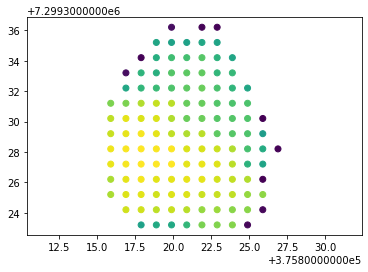

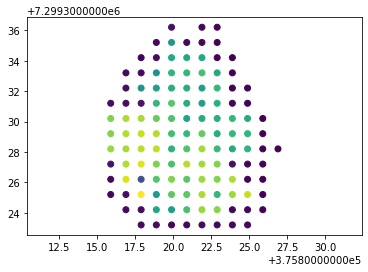

In [13]:
# Plot distribution for fun
maxH = [v[98][0] for v in lc.perc_dict.values()]
medH = [v[50][0] for v in lc.perc_dict.values()]

# Plot
fig, ax = plt.subplots()
ax.scatter(X, Y, c=maxH, cmap='viridis')
ax.axis('equal')

# Plot
# Blegh, median height looks stripy.
fig, ax = plt.subplots()
ax.scatter(X, Y, c=medH, cmap='viridis')
ax.axis('equal')

In [14]:
# Function to compute aggregate pixel metrics based on cover
def coverAggMetrics(cover_dict):
    
    stats = {}
    
    covG = [v['CoverD2'][1] for v in cover_dict.values()]
    
    # Horizontal variation in cover
    stats['max(coverG)'] = np.max(covG)
    stats['min(coverG)'] = np.min(covG)
    stats['range(coverG)'] = np.max(covG) - np.min(covG)
    stats['mean(coverG)'] = np.mean(covG)
    stats['std(coverG)'] = np.std(covG)
    stats['cv(coverG)'] = np.std(covG) / np.mean(covG)
    stats['median(coverG)'] = np.median(covG)
    stats['iqr(coverG)'] = np.percentile(covG, q=75) - np.percentile(covG, q=50)
    
    # Round everything to 3 decimal points
    for k in stats.keys():
        stats[k] = np.round(stats[k], 3)
    
    return stats

In [15]:
stats = coverAggMetrics(lc.cover_dict)
stats

{'max(coverG)': 1.0,
 'min(coverG)': 0.0,
 'range(coverG)': 1.0,
 'mean(coverG)': 0.636,
 'std(coverG)': 0.238,
 'cv(coverG)': 0.375,
 'median(coverG)': 0.658,
 'iqr(coverG)': 0.157}

In [39]:
from scipy.ndimage import gaussian_filter1d

# NOTE: If performing over a set of pixels, need to wrap the below in a loop
def canopyLayerMetrics(h, hbins, plot=False, interpolate=False, smoothsigma=2):
    # Where h is an array of point height values
    # hbins is a list/array of height bin edges
    # smoothsigma = postivie float - gives a smoothing parameter for gaussian smoothing in layer calculation (in meters)
    # interpolate = True/False - whether to interpolate the count data to 5 cm bins, will produce more peaks/layers, but a more precise gapsize
    # plot = True/False - whether to plot the results
    
    # Get dict of heights of points for testing
    h = lc.height_dict[testkey]

    # Get height bins used in processing
    hbins = lc.cover_dict[testkey]['HeightBins']

#     # Make height bins
#     nbins = ((hmax - hmin) / step) + 1
#     heightbins = np.linspace(hmin, hmax, int(nbins))
    
#    # IMPORTANT: Using groundthres, you may want to account for errors in relative accuracy
#     # EX: IF the rel. accuracy of ground is about 0.06 m (6 cm) between flightlines,
#     # the lowest height bin could be set to 0.06 (instead of 0) to account for this.
#     # so any hit below 0.06 m counts as ground.
#     # NOTE: If you want to use everything, just set groundthres to 0
#     if groundthres > 0:
#         # insert the groundthres into the array (right above 0)
#         heightbins = np.insert(heightbins, 1, groundthres)
#         # heightbins[heightbins==0] = groundthres
#     if groundthres < 0:
#         # insert the groundthres into the array (right below 0)
#         heightbins = np.insert(heightbins, 0, groundthres)
#         # heightbins[heightbins==0] = groundthres
        
    # sort points by height
    h = np.sort(h)

    # Group each point by height bin
    hgroups = np.digitize(h, bins=hbins)

    # Count the number of points in each bin
    # Note: minlength allows it to go to the full length of hbins, rather than stop at the max height of the points
    hcounts = np.bincount(hgroups, minlength=len(hbins))

    # Normalize the counts
    hcounts_norm = hcounts/np.sum(hcounts)
    
    # If you want to,
    # Interpolate normalized counts to 5 cm increments so that you have more precise height measurements
    if interpolate:
        hbins = np.arange(0, np.max(hbins), 0.10)
        hcounts_norm = np.interp(x=hbins, xp=lc.cover_dict[testkey]['HeightBins'], fp=hcounts_norm)
    
    # Smooth point height distribution, and find peaks and troughs\
    # Following the below article on stack exchange
    # https://stackoverflow.com/questions/62537703/how-to-find-inflection-point-in-python

    # smooth with gaussian filter (sigma = 2 m)
    smooth = gaussian_filter1d(hcounts_norm, smoothsigma)

    # compute first derivative
    smooth_d1 = np.gradient(smooth)

    # find inflection points
    # when it switches from positive to negative (a trough)
    idx_troughs = np.where(np.diff(np.sign(smooth_d1))>0)[0]
    # when it switches from negative to positive (a peak)
    idx_peaks = np.where(np.diff(np.sign(smooth_d1))<0)[0]

    # output height values of peaks and troughs
    troughs = hbins[idx_troughs]
    peaks = hbins[idx_peaks]
    
    # Get the gap size as the maximum distance between peaks
    gapsize = np.max(np.diff(peaks))

    # Number of layers as number of peaks
    nlayers = len(peaks)
    
    # height location of peak with largest frequency of points
    maxpeakh = peaks[np.argmax(smooth[idx_peaks])]
    
    # computing the PtoH ratio (Davies 2020, Asner 2014)
    perc99 = np.percentile(h, 99)
    ptoh = maxpeakh/perc99
    ptoh = ptoh.round(3)
    
    # Complexity Score (Davies 2020)
    # proportion of bins with points in them vs without
    # could be insensitive to striping
    cscore = np.sum(hcounts>0)/len(hcounts)
    cscore = cscore.round(3)
    
    # Vertical Distribution Ratio (Goetz 2007)
    VDR = (np.max(h) - np.median(h)) / np.max(h)
    VDR = np.round(VDR, 3)
    
    # Foliage Height Diversity 
    # (Bergen 2009 and many others using PAI profile - this is using normalized point counts)
    FHD = -1*np.sum(hcounts_norm*np.log(hcounts_norm, where=hcounts_norm>0))
    FHD = FHD.round(3)
    
    if plot:
        
        fig, ax = plt.subplots()
        ax.plot(hcounts_norm, hbins, label='Raw', lw=2, alpha=0.6)
        ax.plot(smooth, hbins, label='Smoothed', lw=2)
        # for infl in troughs:
        #     tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.6)
        for infl in peaks:
            pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.6)
        # ax.legend(handles=[tline, pline], loc='best')
        ax.legend(loc='best')
        ax.set_xlabel('Normalized Frequency of Points')
        ax.set_ylabel('Height [m]')
        ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
        ax.set_ylim(0, np.max(hbins) + 0.3)
        
        return gapsize, nlayers, maxpeakh, ptoh, cscore, FHD, VDR, peaks, troughs, smooth, fig, ax
    
    else:
        
        return gapsize, nlayers, maxpeakh, ptoh, cscore, FHD, VDR, peaks, smooth, troughs

Gap Size: 8.0 m
Nlayers: 4
Height of max peak: 13.0 m
PtoH Ratio: 0.939
Complexity Score 0.403
Foliage Height Diversity: 2.851
Vertical Distribution Ratio: 0.19699999690055847


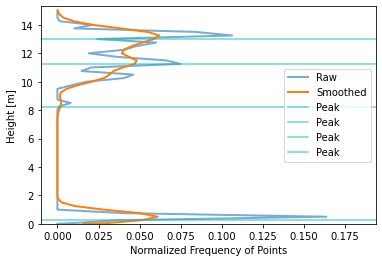

In [43]:
gapsize, nlayers, maxpeakh, ptoh, cscore, FHD, VDR, peaks, troughs, smooth, fig, ax = canopyLayerMetrics(h=lc.height_dict[testkey],
                                                                                                 hbins=lc.cover_dict[testkey]['HeightBins'],
                                                                                                 plot=True,
                                                                                                 smoothsigma=1.5,
                                                                                                 interpolate=False)

print(f'Gap Size: {gapsize} m\nNlayers: {nlayers}\nHeight of max peak: {maxpeakh} m\nPtoH Ratio: {ptoh}\nComplexity Score {cscore}\nFoliage Height Diversity: {FHD}\nVertical Distribution Ratio: {VDR}')

In [20]:
smooth

array([2.61020194e-02, 3.38994571e-02, 4.36388885e-02, 4.75899918e-02,
       4.19544247e-02, 2.95378867e-02, 1.65520041e-02, 7.37264701e-03,
       2.60872213e-03, 7.32856853e-04, 1.63264579e-04, 2.85557804e-05,
       2.70021711e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.90948566e-08, 8.60182103e-07,
       5.14732384e-06, 2.43139393e-05, 9.05380088e-05, 2.65381859e-04,
       6.11995442e-04, 1.11059452e-03, 1.59692761e-03, 1.87588157e-03,
       2.01201902e-03, 2.53329979e-03, 4.28887379e-03, 7.97670850e-03,
       1.35768624e-02, 2.01000832e-02, 2.61496779e-02, 3.11003597e-02,
       3.55238333e-02, 3.99380551e-02, 4.34624961e-02, 4.46426280e-02,
       4.36050251e-02, 4.24504362e-02, 4.33200777e-02, 4.66995102e-02,
       5.13908847e-02, 5.50486423e-02, 5.47525061e-02, 4.85699825e-02,
      

(0.0, 15.3)

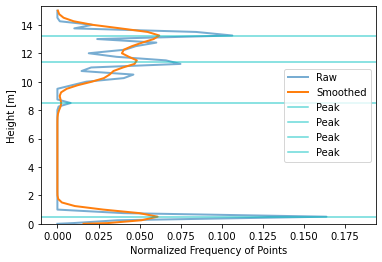

In [96]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d

# Get dict of heights of points for testing
h = lc.height_dict[testkey]

# Get height bins used in processing
hbins = lc.cover_dict[testkey]['HeightBins']

# sort points by height
h = np.sort(h)

# Group each point by height bin
hgroups = np.digitize(h, bins=hbins)

# Count the number of points in each bin
# Note: minlength allows it to go to the full length of hbins, rather than stop at the max height of the points
hcounts = np.bincount(hgroups, minlength=len(hbins))

# Normalize the counts
hcounts_norm = hcounts/np.sum(hcounts)

# Smooth point height distribution, and find peaks and troughs\
# Following the below article on stack exchange
# https://stackoverflow.com/questions/62537703/how-to-find-inflection-point-in-python

# smooth with gaussian filter
smooth = gaussian_filter1d(hcounts_norm, 1.5)

# compute first derivative
smooth_d1 = np.gradient(smooth)

# Interpolate derivative to 1 cm increments so that you have more precise inflection points
hbins_interp= np.arange(0, np.max(hbins), 0.01)
smooth_d1_interp = np.interp(x=hbins_interp, xp=hbins, fp=smooth_d1)

# find inflection points
# when it switches from positive to negative (a trough)
idx_troughs = np.where(np.diff(np.sign(smooth_d1_interp))>0)[0]
# when it switches from negative to positive (a peak)
idx_peaks = np.where(np.diff(np.sign(smooth_d1_interp))<0)[0]

# output height values of peaks and troughs
troughs = hbins_interp[idx_troughs]
peaks = hbins_interp[idx_peaks]

fig, ax = plt.subplots()
ax.plot(hcounts_norm, hbins, label='Raw', lw=2, alpha=0.6)
ax.plot(smooth, hbins, label='Smoothed', lw=2)
# for infl in troughs:
#     tline = ax.axhline(y=infl, color='b', label='Trough', alpha=0.6)
for infl in peaks:
    pline = ax.axhline(y=infl, color='c', label='Peak', alpha=0.6)
# ax.legend(handles=[tline, pline], loc='best')
ax.legend(loc='best')
ax.set_xlabel('Normalized Frequency of Points')
ax.set_ylabel('Height [m]')
ax.set_xlim(-0.01, np.max(hcounts_norm) + 0.03)
ax.set_ylim(0, np.max(hbins) + 0.3)

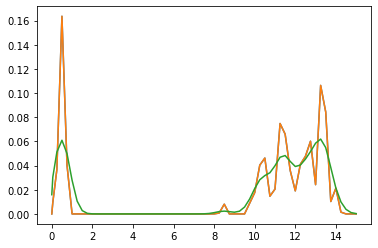

In [93]:
from scipy.interpolate import UnivariateSpline, CubicSpline, interp1d
from scipy.interpolate import splev, splrep

f1d = interp1d(hbins, hcounts_norm)
# fs = splrep(hbins, hcounts_norm)

fig, ax = plt.subplots()
ax.plot(hbins, f1d(hbins))
ax.plot(hbins, hcounts_norm)
ax.plot(hbins, smooth)
# ax.plot(fs[0], fs[1])